## Our goal

In this competition we are asked to predict if a customer will make a transaction or not regardless of the amount of money transacted. Hence our goal is to solve a binary classification problem. In the data description you can see that the features given are numeric and anonymized. Furthermore the data seems to be artificial as they state that "the data has the same structure as our real data". 

### Table of contents

1. [Loading packages](#load) (complete)
2. [Sneak a peek at the data](#data) (complete)
2. [What can we say about the target?](#target) (complete)
3. [Can we find relationships between features?](#correlation) (complete)
4. [Baseline submission](#baselines) (complete)
5. [Basic feature engineering](#engineering) (complete)
6. [Gaussian Mixture Clustering](#clustering) (complete)

## Kernel settings

In [1]:
fit_gaussians = False
use_plotly=True

## Loading packages <a class="anchor" id="load"></a>

In [2]:
# data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

# sklearn models & tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import os
print(os.listdir("../input"))

['train.csv', 'sample_submission.csv', 'test.csv']


In [3]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
submission = pd.read_csv("../input/sample_submission.csv")

## Sneak a peek at the data <a class="anchor" id="data"></a>

### Train

In [4]:
train.shape

(200000, 202)

Ok, 200.000 rows and 202 features. 

In [5]:
train.head(10)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,3.5855,5.9790,0.8010,-0.6192,13.6380,1.2589,8.1939,14.9894,12.0763,-1.4710,6.7341,14.8241,19.7172,11.9882,1.0468,3.8663,4.7252,13.9427,-1.2796,-4.3763,5.1494,0.4124,-5.0732,4.9010,1.5459,15.6423,10.7209,15.1886,1.8685,7.7223,...,16.5552,5.3739,6.4487,11.5631,1.3847,14.9638,2.8455,-9.0953,3.8278,

In [6]:
train.target.dtype

dtype('int64')

In [7]:
org_vars = train.drop(["target", "ID_code"], axis=1).columns.values
len(org_vars)

200

In [8]:
train["Id"] = train.index.values
original_trainid = train.ID_code.values

train.drop("ID_code", axis=1, inplace=True)

The target as well as the ID-Code of a sample are 2 special variables. Consequently 200 features are left. Browsing through the columns we can see that they look really numeric. It seems that there are no counter or integer variables. In addition it looks like if there are no missing values. Let's check it out:

In [9]:
train.isnull().sum().sum()

0

### Test

In [10]:
test.head(10)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846
5,test_5,5.9862,-2.2913,8.6058,7.0685,14.2465,-8.6761,4.2467,14.7632,1.8790,7.2842,-4.9194,-9.1869,14.0581,11.4403,4.2950,13.8808,10.9588,-7.0124,15.1829,18.2710,9.7086,22.9103,6.5080,2.3607,1.7899,13.9555,-7.2154,-2.4084,5.1616,6.9291,0.1141,9.7667,1.2339,17.7117,12.3433,-0.1787,-1.2858,5.5220,13.0498,...,10.4064,5.6731,5.2368,5.2973,-13.2809,26.6

In [11]:
test.isnull().sum().sum()

0

At a first glance this looks similar to train except from the missing target.

In [12]:
test.shape

(200000, 201)

In [13]:
test["Id"] = test.index.values
original_testid = test.ID_code.values

test.drop("ID_code", axis=1, inplace=True)

### Submission

Before we start, let's look at the sample submission as well:

In [14]:
submission.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


Ok, not much to say about it.

## What can we say about the target? <a class="anchor" id="target"></a>

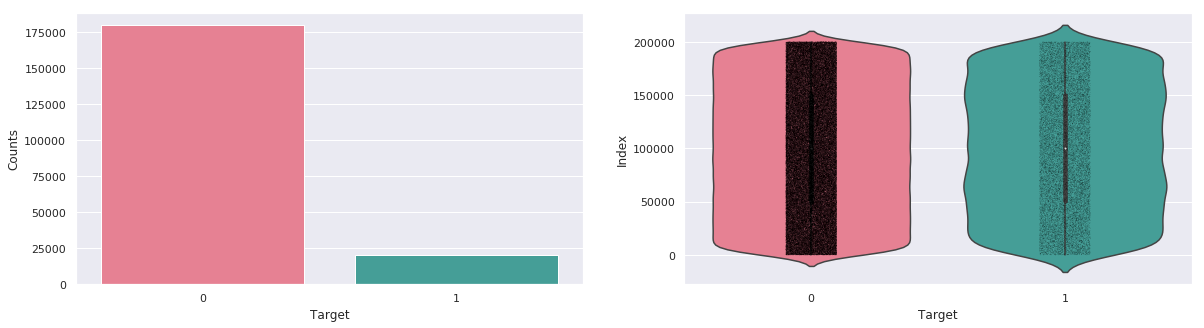

In [15]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(train.target.values, ax=ax[0], palette="husl")
sns.violinplot(x=train.target.values, y=train.index.values, ax=ax[1], palette="husl")
sns.stripplot(x=train.target.values, y=train.index.values,
              jitter=True, ax=ax[1], color="black", size=0.5, alpha=0.5)
ax[1].set_xlabel("Target")
ax[1].set_ylabel("Index");
ax[0].set_xlabel("Target")
ax[0].set_ylabel("Counts");

In [16]:
train.loc[train.target==1].shape[0] / train.loc[train.target==0].shape[0]

0.1117163789174106

### Take Away

* We have to solve an imbalanced class problem. The number of customers that will not make a transaction is much higher than those that will. 
* It seem that there is no relationship of the target with the index of the train dataframe. This is more empressend by the zero targets than for the ones. 
* Take a look at the jitter plots within the violinplots. We can see that the targets look uniformly distributed over the indexes. It seems that the competitors were careful during the process of ordering the data. Once more this indicates that the data is simulated.

## Can we find relationships between features? <a class="anchor" id="correlation"></a>

### Linear correlations

I have already seen some correlation heatmaps in public kernels and it seems as if there is almost no correlation between features. Let's check this out by computing all correlation values and plotting the overall distribution:

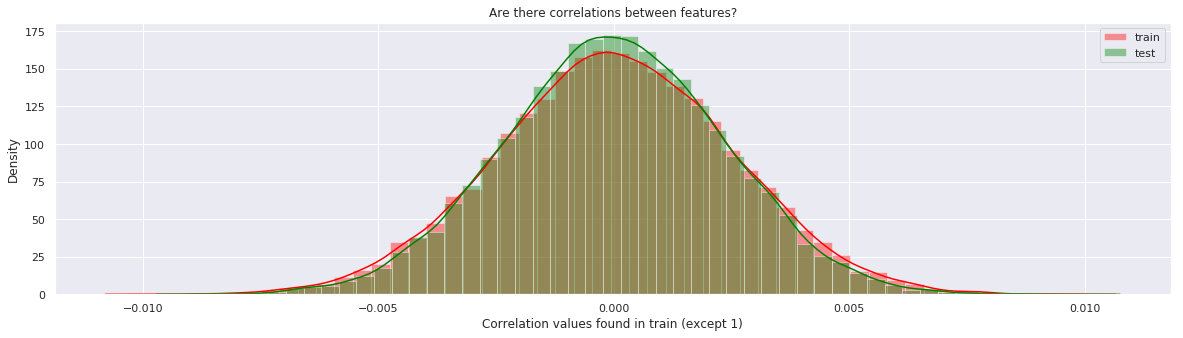

In [17]:
train_correlations = train.drop(["target"], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Red", label="train")
sns.distplot(test_correlations, color="Green", label="test")
plt.xlabel("Correlation values found in train (except 1)")
plt.ylabel("Density")
plt.title("Are there correlations between features?"); 
plt.legend();

Woooow! :-O All features seem to have no linear correlation!!! Neither in train nor in test. Very strange. We know that they are anonymized and perhaps they are decorrelated by some transformation as well. 

### Random Forest Top Features

To start easy, let's use a random forest to select top 10 features. They can serve as a starting point to discover their nature and for trying to understand the data. In addition they may yield some ideas on how to generate new features. I am going to use stratified KFold as a cross validation strategy. It's somehow arbitrary to use KFold as we don't know if we have time series data given, but it may serve as a good starting point. 

To start simple I like to use a random forest that helps us to select important features. As there are no linear correlations it's a good idea to start with a nonlinear model that allows us to discover features, their importances as well as interactions. Let's start! :-)

In [18]:
parameters = {'min_samples_leaf': [20, 25]}
forest = RandomForestClassifier(max_depth=15, n_estimators=15)
grid = GridSearchCV(forest, parameters, cv=3, n_jobs=-1, verbose=2, scoring=make_scorer(roc_auc_score))

In [19]:
grid.fit(train.drop("target", axis=1).values, train.target.values)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_leaf': [20, 25]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=2)

In [20]:
grid.best_score_

0.5088277418503823

You can see that the score is not as good as some other scores of public kernels but nontheless my attempt is to understand the data by improving this score. We can use more powerful models later on.

In [21]:
grid.best_params_

{'min_samples_leaf': 25}

Let's take a look at n_top features of your choice:

In [22]:
n_top = 5 

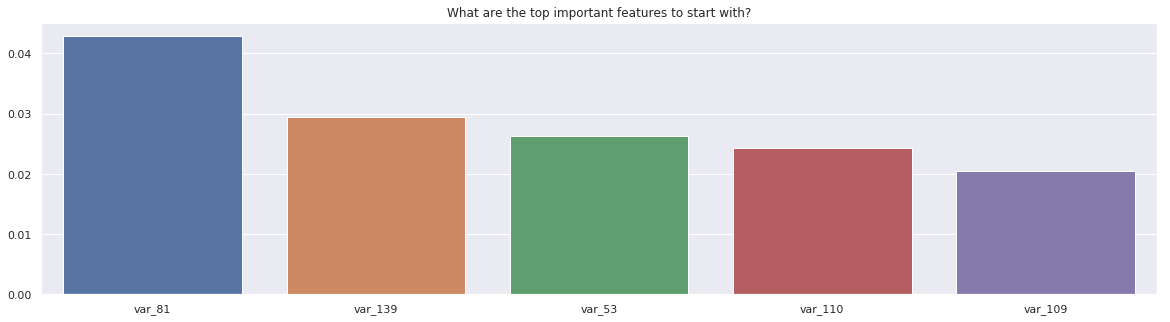

In [23]:
importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = train.drop("target", axis=1).columns.values

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx]);
plt.title("What are the top important features to start with?");

Ok, that's enough to start with the "data-understanding-journey".

### Exploring top features

First of all: How do the distributions of the variables look like with respect to the targets in train? Can we observe discrepancies between train and test features for selected top features?

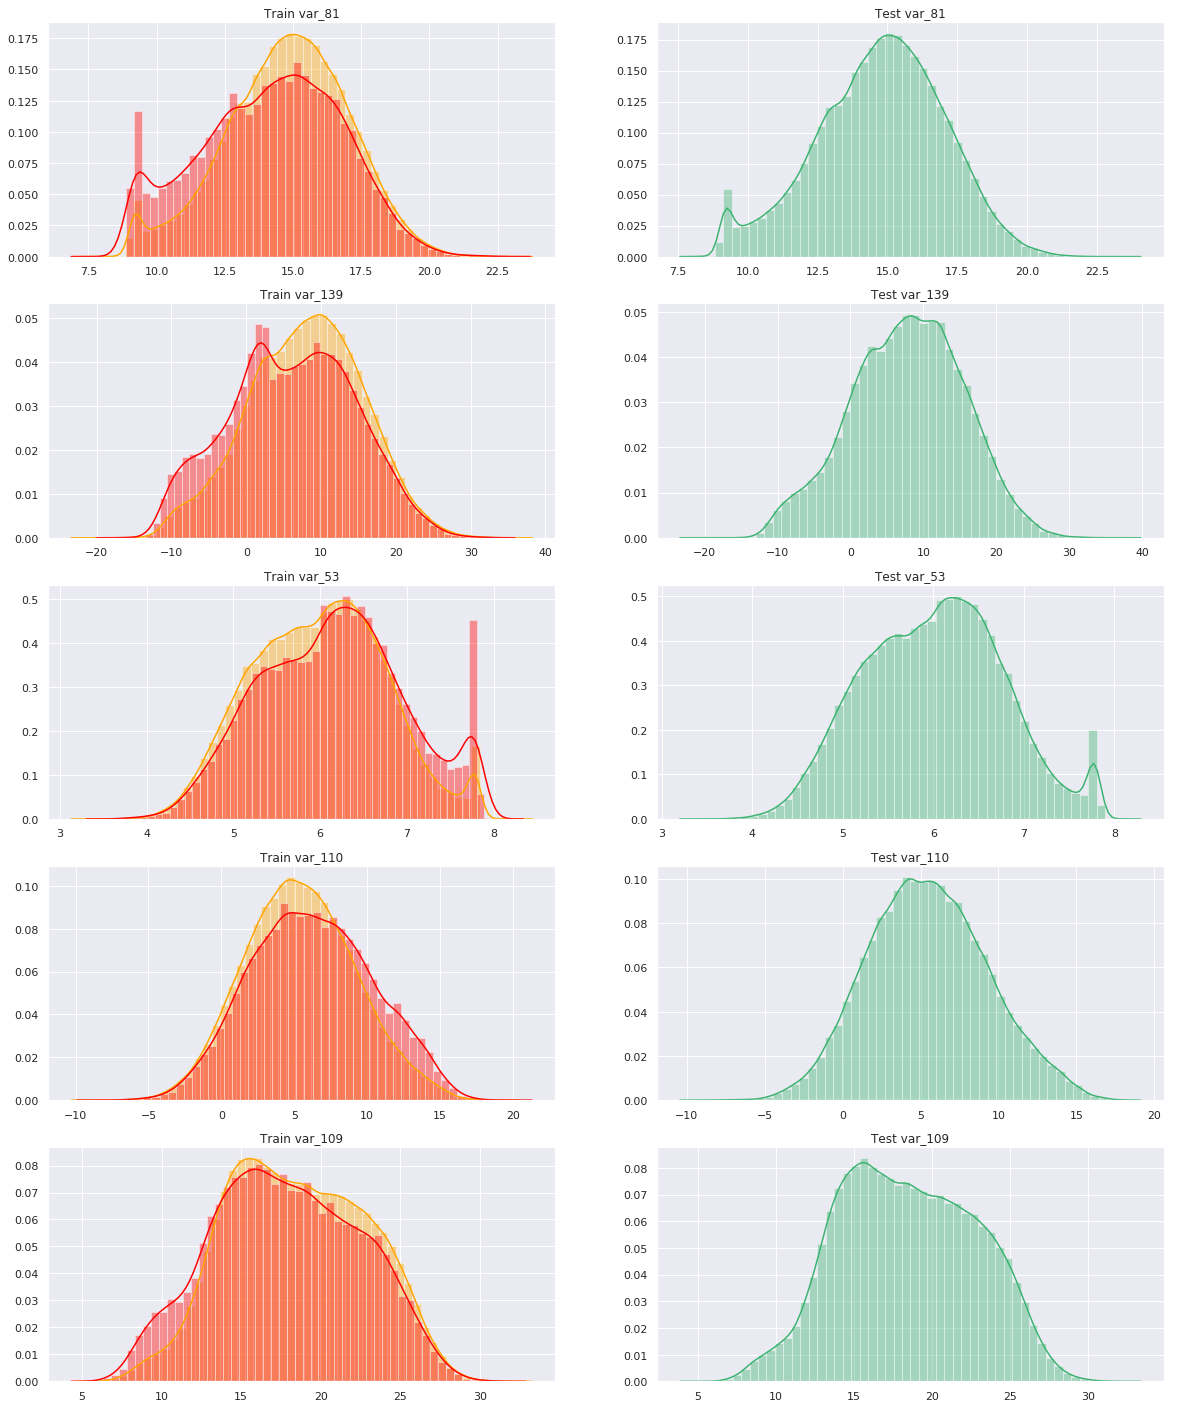

In [24]:
fig, ax = plt.subplots(n_top,2,figsize=(20,5*n_top))

for n in range(n_top):
    sns.distplot(train.loc[train.target==0, feature_names[idx][n]], ax=ax[n,0], color="Orange", norm_hist=True)
    sns.distplot(train.loc[train.target==1, feature_names[idx][n]], ax=ax[n,0], color="Red", norm_hist=True)
    sns.distplot(test.loc[:, feature_names[idx][n]], ax=ax[n,1], color="Mediumseagreen", norm_hist=True)
    ax[n,0].set_title("Train {}".format(feature_names[idx][n]))
    ax[n,1].set_title("Test {}".format(feature_names[idx][n]))
    ax[n,0].set_xlabel("")
    ax[n,1].set_xlabel("")

### Take Away

* Interestingly there are some peeks inside the distributions, especially for variables 81, 12 and 53. Why do these data points accumulate on these values?
* We can observe that the accumulations are less dense in the test data. 
* Variable 174 seem to miss the bulb on the right hand side of the distribution in the test data. 

In [25]:
top = train.loc[:, feature_names[idx]]
top.describe()

,var_81,var_139,var_53,var_110,var_109
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,14.719024,7.760193,6.008569,5.513238,18.458001
std,2.299567,7.686433,0.764753,3.823253,4.355031
min,7.586500,-21.274300,3.344900,-9.239800,5.769700
25%,13.214775,2.387575,5.435600,2.817475,15.107175
50%,14.844500,8.066250,6.027800,5.394300,18.281350
75%,16.340800,13.232525,6.542900,8.104325,21.852900
max,23.132400,36.097100,8.231500,19.519300,32.059100


### How do the scatter plots look like?

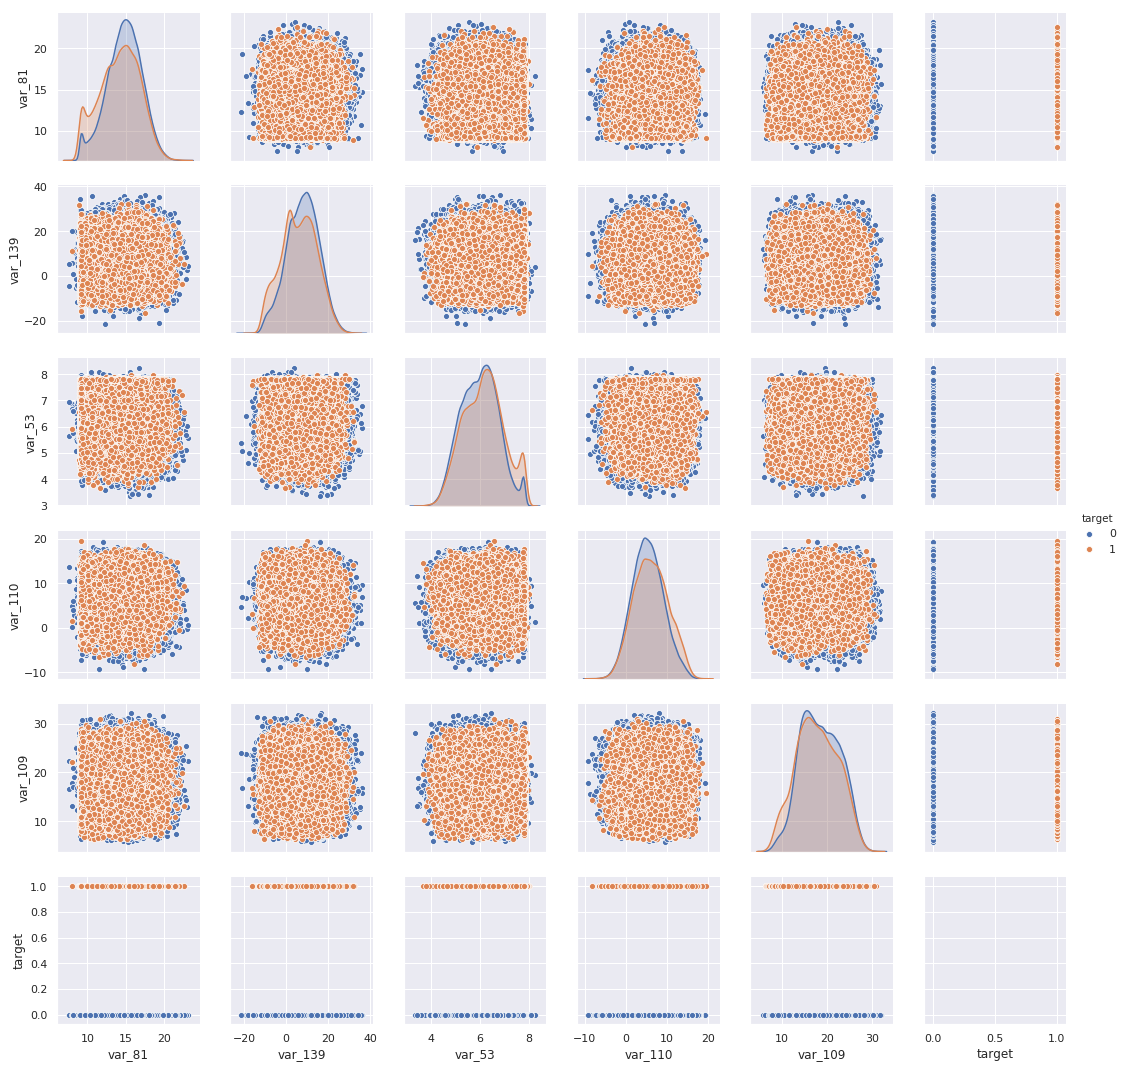

In [26]:
top = top.join(train.target)
sns.pairplot(top, hue="target")

Crazy! Can you see the sharp limits of several variables where the samples with target 1 suddenly accumulate and seldomly pass over. Look at var 81 and 12 for example. You can see that there are limits close to 10 (var 81) and 13.5 (var 12). This finding could be a nice entry point for further feature engineering.

## Baseline submissions 

### What score does the forest yield on public LB?

In [27]:
y_proba = grid.predict_proba(test.values)
y_proba_train = grid.predict_proba(train.drop("target", axis=1).values)

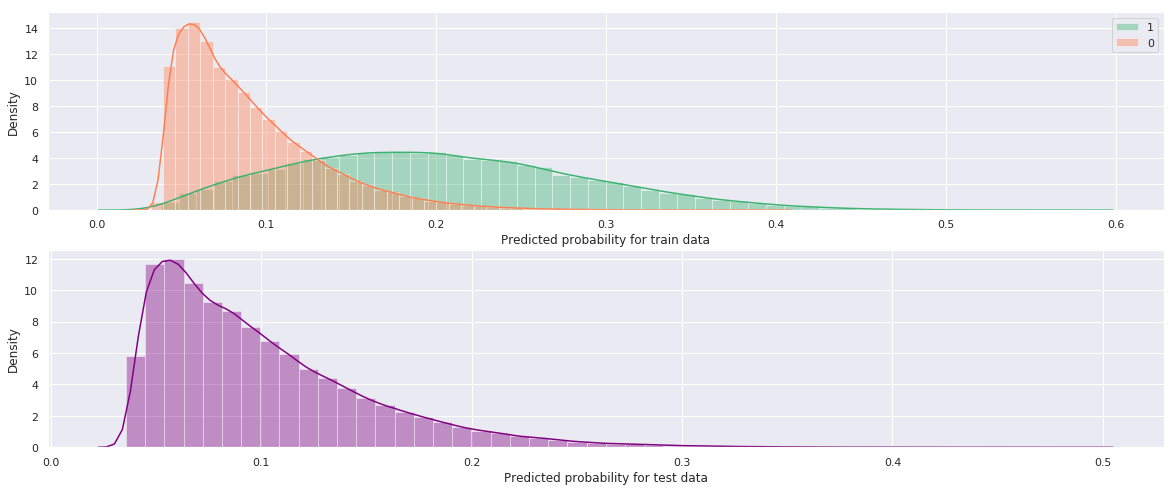

In [28]:
fig, ax = plt.subplots(2,1,figsize=(20,8))
sns.distplot(y_proba_train[train.target==1,1], norm_hist=True, color="mediumseagreen",
             ax=ax[0], label="1")
sns.distplot(y_proba_train[train.target==0,1], norm_hist=True, color="coral",
             ax=ax[0], label="0")
sns.distplot(y_proba[:,1], norm_hist=True,
             ax=ax[1], color="purple")
ax[1].set_xlabel("Predicted probability for test data");
ax[1].set_ylabel("Density");
ax[0].set_xlabel("Predicted probability for train data");
ax[0].set_ylabel("Density");
ax[0].legend();

In [29]:
submission["target"] = y_proba

In [30]:
submission.to_csv("submission_baseline_forest.csv", index=False)

Yields 0.662 on public LB.

## Feature engineering 

Let's do some basic feature engineering. Perhaps it helps to improve:

In [31]:
original_features = train.drop(["target", "Id"], axis=1).columns.values
original_features

array(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8', 'var_9', 'var_10', 'var_11', 'var_12', 'var_13',
       'var_14', 'var_15', 'var_16', 'var_17', 'var_18', 'var_19',
       'var_20', 'var_21', 'var_22', 'var_23', 'var_24', 'var_25',
       'var_26', 'var_27', 'var_28', 'var_29', 'var_30', 'var_31',
       'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37',
       'var_38', 'var_39', 'var_40', 'var_41', 'var_42', 'var_43',
       'var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49',
       'var_50', 'var_51', 'var_52', 'var_53', 'var_54', 'var_55',
       'var_56', 'var_57', 'var_58', 'var_59', 'var_60', 'var_61',
       'var_62', 'var_63', 'var_64', 'var_65', 'var_66', 'var_67',
       'var_68', 'var_69', 'var_70', 'var_71', 'var_72', 'var_73',
       'var_74', 'var_75', 'var_76', 'var_77', 'var_78', 'var_79',
       'var_80', 'var_81', 'var_82', 'var_83', 'var_84', 'var_85',
       'var_86', 'var_87', 'var_88', 'var_89', 'var_

### Rounding & quantile based binning

In [32]:
encoder = LabelEncoder()
for your_feature in top.drop("target", axis=1).columns.values:
    train[your_feature + "_qbinned"] = pd.qcut(
        train.loc[:, your_feature].values,
        q=10,
        labels=False
    )
    train[your_feature + "_qbinned"] = encoder.fit_transform(
        train[your_feature + "_qbinned"].values.reshape(-1, 1)
    )
    
    
    train[your_feature + "_rounded"] = np.round(train.loc[:, your_feature].values)
    train[your_feature + "_rounded_10"] = np.round(10*train.loc[:, your_feature].values)
    train[your_feature + "_rounded_100"] = np.round(100*train.loc[:, your_feature].values)

### New feature importances

In [33]:
cv = StratifiedKFold(n_splits=3, random_state=0)
forest = RandomForestClassifier(max_depth=15, n_estimators=15, min_samples_leaf=20,
                                n_jobs=-1)

scores = []
X = train.drop("target", axis=1).values
y = train.target.values

for train_idx, test_idx in cv.split(X, y):
    x_train = X[train_idx]
    x_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    forest.fit(x_train, y_train)
    y_proba = forest.predict_proba(x_test)
    y_pred = np.zeros(y_proba.shape[0])
    y_pred[y_proba[:,1] >= 0.166] = 1
    
    score = roc_auc_score(y_test, y_pred)
    print(score)
    scores.append(score)

print(np.round(np.mean(scores),4))
print(np.round(np.std(scores), 4))

0.6539890478902182
0.6531458774934066
0.5000583654343222
0.6024
0.0724


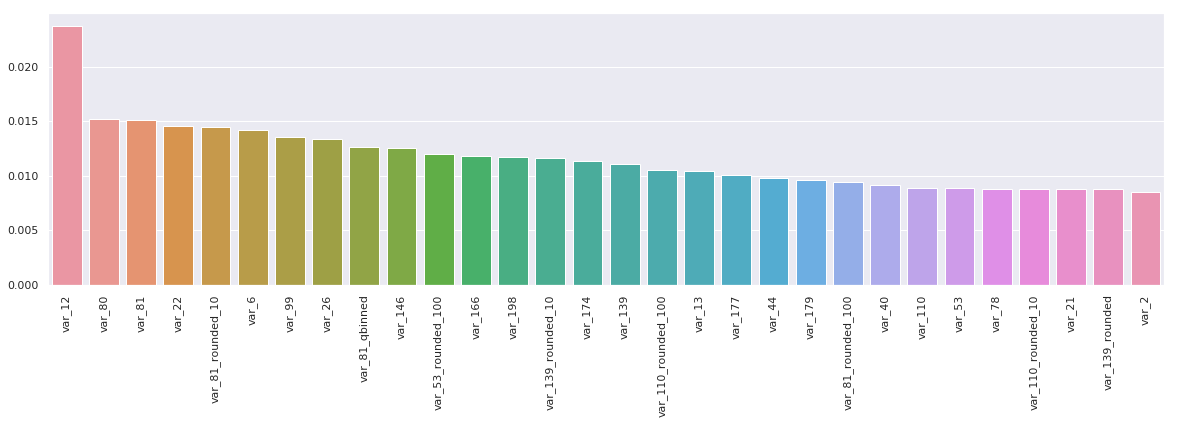

In [34]:
importances = forest.feature_importances_
feature_names = train.drop("target", axis=1).columns.values
idx = np.argsort(importances)[::-1][0:30]

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx]);
plt.xticks(rotation=90);

## Gaussian Mixture Clustering  <a class="anchor" id="clustering"></a>

The majority of the data looks like a big gaussian distribution. Besides that there seems to be at least one or two more gaussians that could explain the second and third mode that we can find for important features. Let's motivate this even further by looking at scatter and kde-plots of some top-features:

In [35]:
col1 = "var_81"
col2 = "var_12"
N=70000

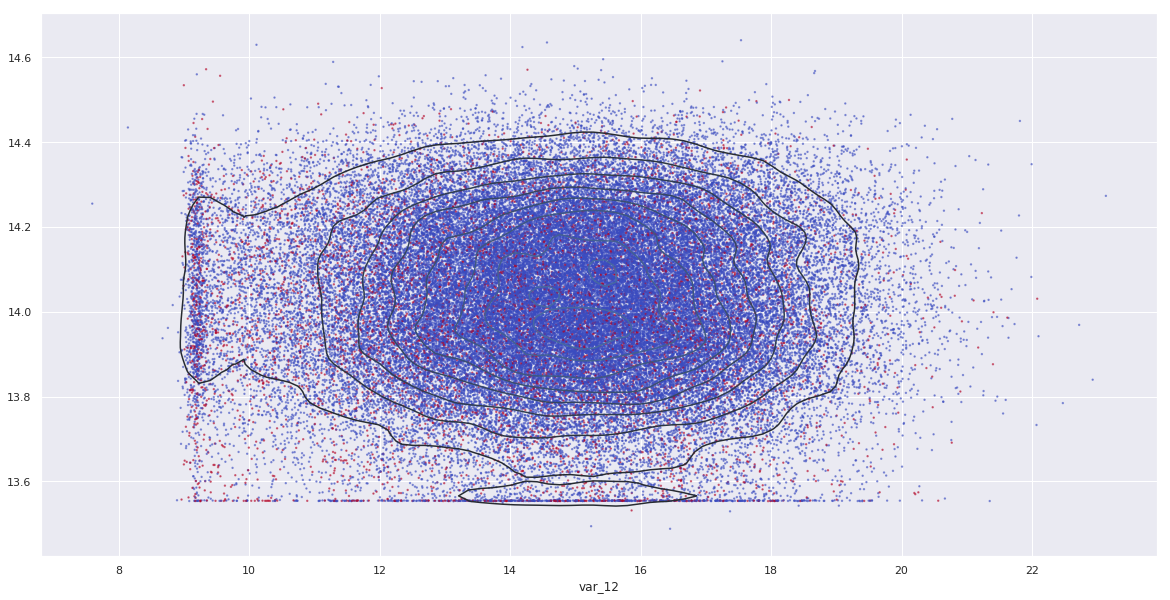

In [36]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.kdeplot(train[col1].values[0:N], train[col2].values[0:N])
ax.scatter(train[col1].values[0:N], train[col2].values[0:N],
           s=2, c=train.target.values[0:N], cmap="coolwarm", alpha=0.5)
ax.set_xlabel(col1)
ax.set_xlabel(col2);

* At least one big gaussians with one or two small, very thin but long gaussians.
* It's very interesting that we can still find outliers beside sharp lines. 

Let's assume now that the data was generated using a mixture of gaussians and let's try to cluster them. Perhaps we can see that some clusters occupy more hot targets than others.

In [37]:
combined = train.drop(["target", "Id"], axis=1).append(test.drop("Id", axis=1))
combined.shape

(400000, 220)

In [38]:
max_components = 10
start_components = 3
n_splits = 3
K = train.shape[0]

X = train.loc[:, original_features].values[0:K]
y = train.target.values[0:K]

In [39]:
seeds = np.random.RandomState(0).randint(0,100, size=(max_components-start_components))
seeds

array([44, 47, 64, 67, 67,  9, 83])

In [40]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
if fit_gaussians:
    components = np.arange(start_components, max_components, 1)
    kf = StratifiedKFold(random_state=0, n_splits=n_splits)
    
    scores = np.zeros(shape=(max_components-start_components, n_splits))

    for m in components:
        split=0
        print("Components " + str(m))
        for train_index, test_index in kf.split(X_scaled, y):
            print("Split " + str(split))
            x_train, x_test = X_scaled[train_index], X_scaled[test_index]
            gm = GaussianMixture(n_components=m, random_state=seeds[m-start_components])
            gm.fit(x_train)
            score = gm.score(x_test)
            scores[m-start_components,split] = score
            split +=1
    
    print(np.round(np.mean(scores, axis=1), 2))
    print(np.round(np.std(scores, axis=1), 2))
    best_idx = np.argmax(np.mean(scores, axis=1))
    best_component = components[best_idx]
    best_seed = seeds[best_idx]
    print("Best component found " + str(best_component))
    
else:
    best_seed = seeds[0]
    best_component = 3

In [42]:
X = train.loc[:, original_features].values

gm = GaussianMixture(n_components=best_component, random_state=best_seed)
X_scaled = scaler.transform(X)
gm.fit(X_scaled)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=44, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [43]:
train["cluster"] = gm.predict(X_scaled)
train["logL"] = gm.score_samples(X_scaled)
test["cluster"] = gm.predict(test.loc[:, original_features].values)
test["logL"] = gm.score_samples(test.loc[:, original_features].values)

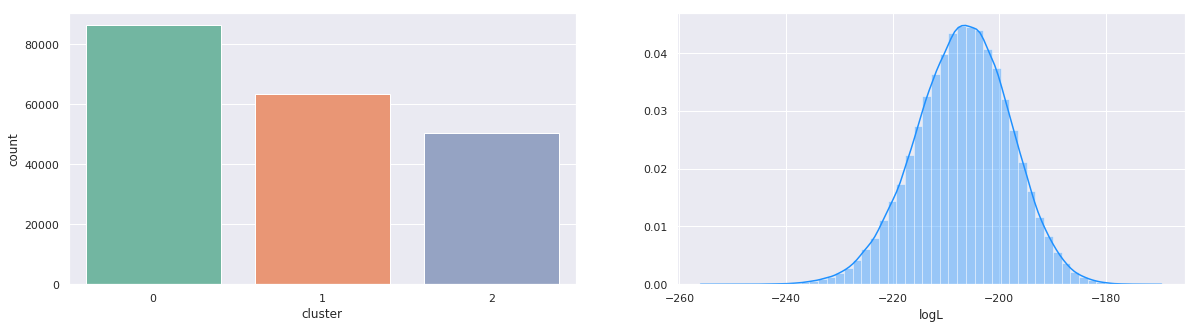

In [44]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(train.cluster, palette="Set2", ax=ax[0])
sns.distplot(train.logL, color="Dodgerblue", ax=ax[1]);

### Take-Away

* By fitting the gaussian mixture model we are maximizing the log likelihood. The higher, the better the gaussians suite to our data. As it's difficult to choose the right number of components (gaussians) I decided to use a stratified k fold of the train data. This way we can fit gaussians to a train subset, and test how big the log likelihood is on the test subset. By doing so three times for each selected component, we gain some more information about the stability of our solution. **We can see that 3 gaussians seem to be sufficient as the log likelihood values decrease with more components**. 
* This need not be true as the **solution depends on the initialization of the gaussians (the seeds I used) and with more data, the result may be different**. 
* But we can say: There are **at least 3 gaussians**. This is what we have already found by visual exploration of the data. 
* The individual score per data spot can be understood as a measure of density. If it's low, the data spot lives in a region with other data points far away. If it's high, it should have a lot of neighbors. Consequently the individual logL-score can tell us something about outliers in the data.

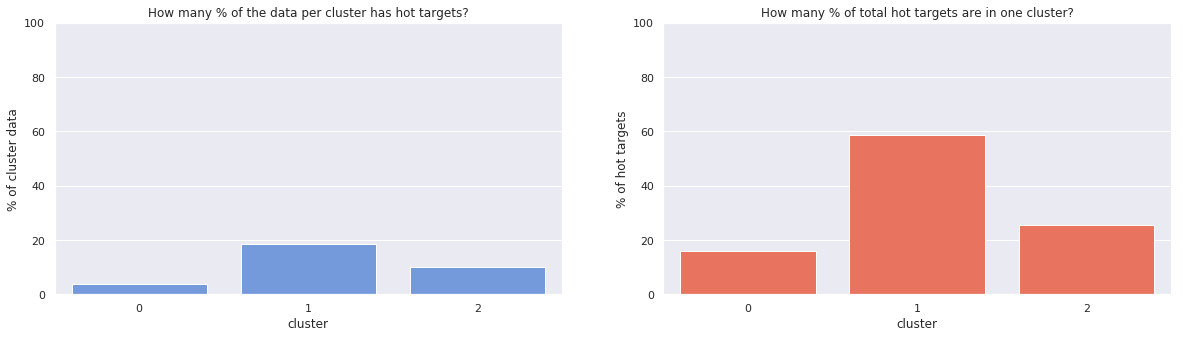

In [45]:
cluster_occupation = train.groupby("cluster").target.value_counts() / train.groupby("cluster").size() * 100
cluster_occupation = cluster_occupation.loc[:, 1]

target_occupation = train.groupby("target").cluster.value_counts() / train.groupby("target").size() * 100
target_occupation = target_occupation.loc[1, :]
target_occupation.index = target_occupation.index.droplevel("target")

fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_title("How many % of the data per cluster has hot targets?")
sns.barplot(cluster_occupation.index, cluster_occupation.values, ax=ax[0], color="cornflowerblue")
ax[0].set_ylabel("% of cluster data")
ax[0].set_ylim([0,100])

ax[1].set_title("How many % of total hot targets are in one cluster?")
sns.barplot(target_occupation.index, target_occupation.values, ax=ax[1], color="tomato")
ax[1].set_ylabel("% of hot targets")
ax[1].set_ylim([0,100]);

* As we have much more cold-targets (zero) that hot (ones), I'm not surprised that hot targets occupy only a small part of the data per cluster. Nonetheless we can see that cluster 1 has significantly more hot targets than the others.
* The second plot shows that most hot targets are located in cluster 1 followed by cluster 2. This confirms our assumption that the big gaussian in the middle (cluster 0) has the smallest amount of hot targets and that the small, thin side distributions are more likely to have hot targets. 

Text(0.5, 0, 'Feature')

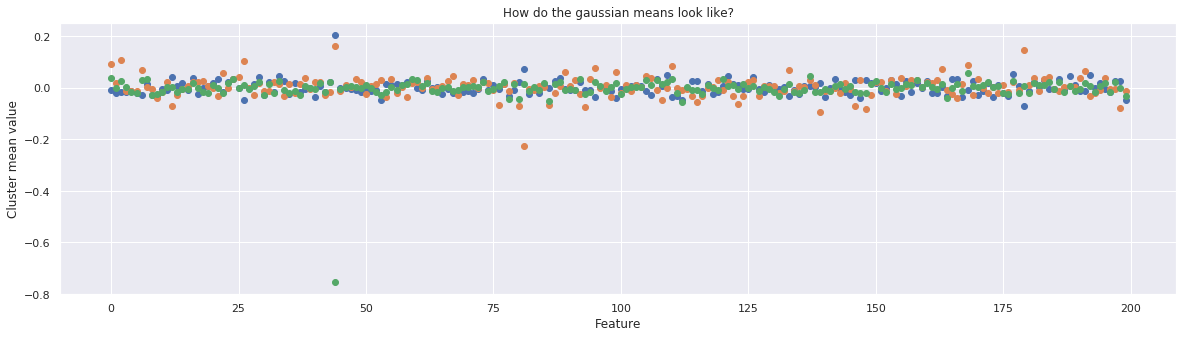

In [46]:
plt.figure(figsize=(20,5))
for n in range(gm.means_.shape[0]):
    plt.plot(gm.means_[n,:], 'o')
plt.title("How do the gaussian means look like?")
plt.ylabel("Cluster mean value")
plt.xlabel("Feature")

Only some features are important to separate the structure of the data. 

Good luck for the last days! :-)